# Example 12-1: Dirichlet boundary conditions

So far we've only solved initial value problems where conditions are prescribed at the left end of the solution interval, i.e., at $t = 0$.
When conditions are prescribed for both ends of the solution interval, we get a **boundary value problem** (BVP), which we will explore in this section.
We begin with defining a few different classes of BVPs and **direct methods** for solving them.

## Summary of commands

In this exercise, we will demonstrate the following new commands:
- [`np.diag(x, k)`](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) - Construct a diagonal 2D array from the 1D array `x`, placing it on the `k`th diagonal.
    - Note: The main diagonal ($a_{11}$, $a_{22}$, $a_{33}$, ...) is $k=0$. $k > 0$ is above and $k < 0$ is below.
- [`np.ones(shape)`](https://numpy.org/doc/stable/reference/generated/numpy.ones.html) - Create an array of the given `shape` of all `1`s.
- [`np.linalg.solve(A, b)`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) - Computes the solution $\vec{x}$ to the matrix equation $A \vec{x} = \vec{b}$.
    - Note: This is the NumPy analog of the classic MATLAB expression `x = A \ b`.
- [`np.concatenate([M1, M2, ...], axis)`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) - Join a sequence of arrays `M1`, `M2`, ... along the given `axis`.
  Array dimensions must be consistent.
- [`ax.annotate(text, xy, ...)`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html) - Place the `text` string at the position `xy`.
    - Many other options available! Read more for details.

## Direct methods

The idea behind direct methods is to use a **finite difference scheme** to discretize the derivatives, transforming a calculus problem into a linear algebra one. (fun!)
The resulting matrix equation can then be solved using standard linear algebra tools in a single operation ("directly").
The tricky thing is **setting up the coefficients in the `A` matrix** and remembering to enforce the proper boundary conditions.

Because the discretization of derivatives only accounts for neighboring points, the general structure of these problems looks like the following:

$$ \begin{pmatrix} 
b_2 & c_2 & \ & \ & \ & \ & \ \\
a_3 & b_3 & c_3 & \ & \ & \ & \ \\
\ & a_4 & b_4 & c_4 & \ & 0 & \ \\
\ & \ & \ddots & \ddots & \ddots & \ & \ \\
\ & 0 & \ & a_{N-3} & b_{N-3} & c_{N-3} & \ \\
\ & \ & \ & \ & a_{N-2} & b_{N-2} & c_{N-2} \\
\ & \ & \ & \ & \ & a_{N-1} & b_{N-1}
\end{pmatrix} 
\begin{pmatrix}
y_2 \\ y_3 \\ y_4 \\ \vdots \\ y_{N-3} \\ y_{N-2} \\ y_{N-1} 
\end{pmatrix} = 
\begin{pmatrix}
f_2 \\ f_3 \\ f_4 \\ \vdots \\ f_{N-3} \\ f_{N-2} \\ f_{N-1}
\end{pmatrix}
$$

The large coefficient matrix is **tridiagonal**, and we can easily construct it by specifying the three individual arrays $\vec{a}$, $\vec{b}$, and $\vec{c}$ and placing them on the proper diagonal using `np.diag(v, k)`.
As always, this is best explained with an example:

-----------------------

The following ODE is solved using the direct method with 21 equally spaced points ($N = 21$) over the interval $x = [x_L, x_R] = [0, 1]$.

$$ y'' - 3y' + 2y = \cos x $$

The boundary conditions are

$$ y(x_L) = y_L = 1.43 \quad  \text{and} \quad y(x_R) = y_R = 3.82 $$

These are **Dirichlet boundary conditions** because they fix the value of the function (as opposed to its derivatives).
Using the proper discretization scheme and referring to the matrix of coefficients above, we will find that:

$$ \begin{align}
a_j &= 1 + \frac{3h}{2} \\
b_j &= 2h^2 - 2 \\
c_j &= 1 - \frac{3h}{2}
\end{align} $$

and

$$ \begin{align}
f_2 &= h^2 \cos(x_2) - \left(1 + \frac{3h}{2} \right) y_L \\
f_j &= h^2 \cos(x_j) \\
f_{N-1} &= h^2 \cos(x_{N-1}) - \left( 1 - \frac{3h}{2} \right) y_R
\end{align} $$

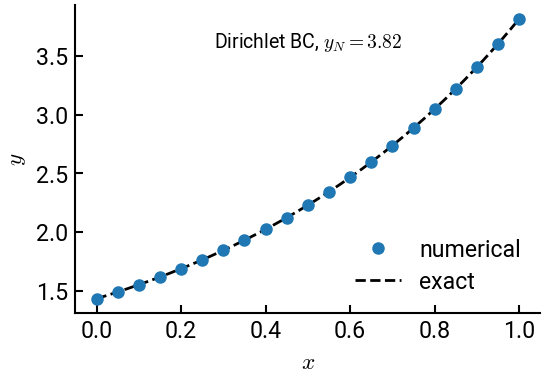

In [4]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# helper function to make tridiagonal matrices
def make_tridiag(a, b, c):
    """ For convenience, a, b, c should all be the same length.
        The function will automatically subset and place on the 
        corresponding diagonal. """
    return np.diag(a[1:], -1) + np.diag(b, 0) + np.diag(c[:-1], 1)

# constants
N = 21
yL = 1.43
yR = 3.82
xL = 0
xR = 1
h = (xR - xL) / (N - 1)
x = np.linspace(xL, xR, N)

# construct matrix - pay attention to number of nodes!
a = np.ones(N - 2) * 1 + 3 * h / 2
b = np.ones(N - 2) * 2 * h**2 - 2
c = np.ones(N - 2) * 1 - 3 * h / 2
A = make_tridiag(a, b, c)

# construct f and solve
f = np.cos(x[1:-1]) * h**2            # general solution for interior
f[0] -= (1 + 3 * h / 2) * yL          # modify for left BC
f[-1] -= (1 - 3 * h / 2) * yR         # modify for right BC
y = np.linalg.solve(A, f)             # solve for y in Ay = f
y = np.concatenate([[yL], y, [yR]])   # add boundary conditions back

# exact solution
x1 = np.linspace(xL, xR, 10000)
y_exact = 1.2437 * np.exp(x1) + 0.0863 * np.exp(2 * x1) - 3/10 * np.sin(x1) + 1/10 * np.cos(x1)

# plot the result
fig, ax = plt.subplots()
ax.plot(x, y, 'o', label='numerical')
ax.plot(x1, y_exact, 'k--', lw=2, label='exact', zorder=-5)
ax.set(xlabel='$x$', ylabel='$y$')
ax.annotate("Dirichlet BC, $y_N = 3.82$", (0.5, 3.57), ha='center', fontsize=14)
ax.legend()
plt.show()